# Домашнее задание № 9. Предобученные трансформеры

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [1]:
!pip3 install scikit-learn pandas matplotlib transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00


In [2]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)
data.shape

(607, 6)

#bert-base-multilingual-cased'

In [8]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-cased', trainable=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [10]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [11]:
model_clf.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=20)

Epoch 1/20


144/144 [==============================] - 120s 520ms/step - loss: 2.8294 - accuracy: 0.0851 - rec_prec: 0.0000e+00 - val_loss: 2.6659 - val_accuracy: 0.1613 - val_rec_prec: 0.0323
Epoch 2/20
144/144 [==============================] - 73s 507ms/step - loss: 2.8145 - accuracy: 0.0660 - rec_prec: 0.0000e+00 - val_loss: 2.7105 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 3/20
144/144 [==============================] - 74s 511ms/step - loss: 2.7695 - accuracy: 0.1024 - rec_prec: 0.0000e+00 - val_loss: 2.6945 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 4/20
144/144 [==============================] - 74s 516ms/step - loss: 2.7559 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.6549 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
144/144 [==============================] - 74s 514ms/step - loss: 2.7127 - accuracy: 0.0903 - rec_prec: 0.0000e+00 - val_loss: 2.6136 - val_accuracy: 0.1613 - val_rec_prec: 0.0000e+00
Epoch 6/20
144/144 [===================

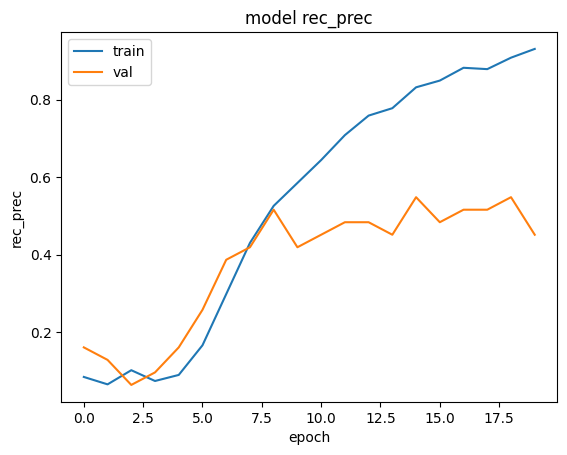

In [12]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 4s 184ms/step
                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
         Культура       0.40      0.67      0.50         3
         Ценности       0.00      0.00      0.00         2
            Спорт       1.00      1.00      1.00         2
              Мир       0.00      0.00      0.00         1
  Наука и техника       0.67      0.67      0.67         3
        Экономика       0.00      0.00      0.00         2
      Бывший СССР       0.50      0.33      0.40         3
Силовые структуры       0.00      0.00      0.00         2
   Интернет и СМИ       0.50      0.50      0.50         2
           Бизнес       0.25      0.50      0.33         2
   69-я параллель       1.00      1.00      1.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       1.00      1.00      1.00         1
         Из жизни       0.67      0.67      0.67         3
  

#cointegrated/rubert-tiny

In [14]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_bert = TFAutoModel.from_pretrained("cointegrated/rubert-tiny", from_pt=True, trainable=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [15]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [16]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [20]:
model_clf.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=50)

Epoch 1/50
144/144 [==============================] - 8s 55ms/step - loss: 2.5676 - accuracy: 0.1649 - rec_prec: 0.0017 - val_loss: 2.5408 - val_accuracy: 0.2258 - val_rec_prec: 0.0323
Epoch 2/50
144/144 [==============================] - 7s 51ms/step - loss: 2.5477 - accuracy: 0.1771 - rec_prec: 0.0000e+00 - val_loss: 2.5333 - val_accuracy: 0.1935 - val_rec_prec: 0.0323
Epoch 3/50
144/144 [==============================] - 7s 50ms/step - loss: 2.5059 - accuracy: 0.2326 - rec_prec: 0.0017 - val_loss: 2.5258 - val_accuracy: 0.2581 - val_rec_prec: 0.0000e+00
Epoch 4/50
144/144 [==============================] - 7s 51ms/step - loss: 2.5046 - accuracy: 0.2101 - rec_prec: 0.0139 - val_loss: 2.5172 - val_accuracy: 0.2581 - val_rec_prec: 0.0000e+00
Epoch 5/50
144/144 [==============================] - 7s 51ms/step - loss: 2.4556 - accuracy: 0.2101 - rec_prec: 0.0122 - val_loss: 2.5090 - val_accuracy: 0.2581 - val_rec_prec: 0.0000e+00
Epoch 6/50
144/144 [==============================] - 7s 50

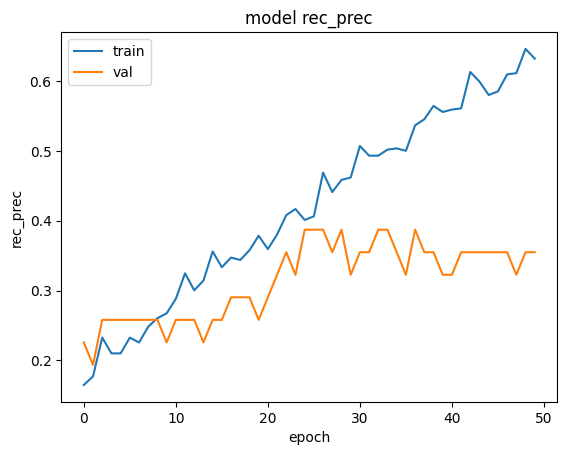

In [21]:
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 0s 25ms/step
                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
         Культура       1.00      0.67      0.80         3
         Ценности       0.00      0.00      0.00         2
            Спорт       1.00      1.00      1.00         2
              Мир       0.00      0.00      0.00         1
  Наука и техника       0.25      0.33      0.29         3
        Экономика       0.00      0.00      0.00         2
      Бывший СССР       0.00      0.00      0.00         3
Силовые структуры       0.33      1.00      0.50         2
   Интернет и СМИ       0.33      0.50      0.40         2
           Бизнес       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
         Из жизни       0.50      0.67      0.57         3
   

# benjamin/wtp-bert-mini

In [26]:
tokenizer = AutoTokenizer.from_pretrained('Geotrend/bert-base-ru-cased')
model_rubert = TFAutoModel.from_pretrained('Geotrend/bert-base-ru-cased', trainable=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-

In [27]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [28]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_rubert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf_r = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf_r.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [29]:
model_clf_r.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=4,
         epochs=20)

Epoch 1/20


144/144 [==============================] - 119s 540ms/step - loss: 2.8648 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.7611 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
144/144 [==============================] - 71s 496ms/step - loss: 2.7873 - accuracy: 0.0590 - rec_prec: 0.0000e+00 - val_loss: 2.7343 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 3/20
144/144 [==============================] - 72s 502ms/step - loss: 2.7775 - accuracy: 0.0799 - rec_prec: 0.0000e+00 - val_loss: 2.7115 - val_accuracy: 0.1935 - val_rec_prec: 0.0000e+00
Epoch 4/20
144/144 [==============================] - 71s 492ms/step - loss: 2.7437 - accuracy: 0.0938 - rec_prec: 0.0000e+00 - val_loss: 2.6560 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 5/20
144/144 [==============================] - 71s 492ms/step - loss: 2.6406 - accuracy: 0.1736 - rec_prec: 0.0000e+00 - val_loss: 2.4583 - val_accuracy: 0.2258 - val_rec_prec: 0.0000e+00
Epoch 6/20
144/144 [===============

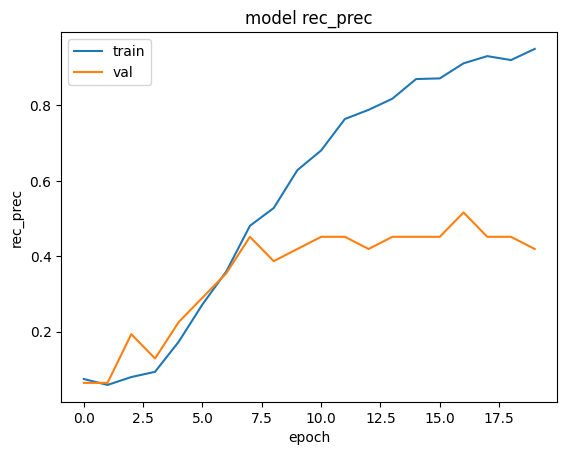

In [30]:
plt.plot(model_clf_r.history.history['accuracy'])
plt.plot(model_clf_r.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
pred = model_clf_r.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 [==============================] - 5s 184ms/step
                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
         Культура       0.67      0.67      0.67         3
         Ценности       0.50      0.50      0.50         2
            Спорт       1.00      0.50      0.67         2
              Мир       0.00      0.00      0.00         1
  Наука и техника       0.67      0.67      0.67         3
        Экономика       0.50      1.00      0.67         2
      Бывший СССР       0.00      0.00      0.00         3
Силовые структуры       0.50      0.50      0.50         2
   Интернет и СМИ       0.50      0.50      0.50         2
           Бизнес       0.67      1.00      0.80         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
         Из жизни       0.33      0.33      0.33         3
  

### Итоги

В целом, по всем метрикам результаты не больше единицы. Но лучшие результаты показывает первая модель, rubert-base-cased-sentiment-rurewiews. Вторая по результатам - benjamin/wtp-bert-mini. Возможно, существует коррелляция между размером модели и её продуктивностью.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT?

### **1**

ROBERTA описана в статье ***RoBERTa: A Robustly Optimized BERT Pretraining Approach (https://arxiv.org/abs/1907.11692)*** Она отличается от BERT по нескольким параметрам:

1) объём данных, на которых она тренировалась (в 10 раз больше);

благодаря этому RoBERTa обладает значительно более обширным словарем, однако и время ее обучения существенно больше.

2) система динамического маскирования токенов (есть у ROBERTA, нет у BERT);

это обеспечивает большую гибкость модели, которая на каждом этапе обучения учитывает различные распределения токенов в разных контекстах.

3) обучение на задаче next-sentence-prediction (нет у ROBERTA, есть у BERT)

### **2**

T5 в отличие от BERT и ROBERTA натренирована в основном на генерацию текста, а не на lagnuage understanding (вопрос-ответ, классификация), как берт и подобные модели. Она тренируется на больших данных и имеет энкодер и декодер (в то время как BERT - только энкодер).

Исходя из задачи генерации текста, отличаются и вводные данные: Т5 получает на вход текстовую строку, а не эмбеддинги.

